# Evaluation of all services

* We compute metrics for all 5 services with all 7 evaluator classes (for Gender API and NameAPI we have two approaches)
* We export the tables with those variants of Gender API and NameAPI that perform better
* We compute benchmarks for 3 different metrics by tuning/training the free parameter(s) and reporting the cross validation error

In [1]:
import pandas as pd
import xlsxwriter
from collections import OrderedDict, Counter

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import seaborn as sns
sns.set(color_codes=True)

from evaluators import *
from evaluator import *
from helpers import REGISTERED_EVALUATORS
from __init__ import DIR_PATH

%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/helena.mihaljevic-br/.virtualenvs/name-based-inference/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
# Color codes for tables
light_green = '#e5ffe5'
dark_green = '#2e992e'

In [3]:
gender_evalautor_to_service_name = {'gender_api': 'Gender API', 'gender_guesser': 'gender-guesser', 
                                    'genderize_io': 'genderize.io', 'name_api_full': 'NameAPI', 'namsor': 'NamSor'}
def reduce_table(df, by_index):
    """Filter rows or columns of a benchmark table and rename."""
    df = df.sort_index()
    if by_index:
        df = df.loc[gender_evalautor_to_service_name.keys()]
        df = df.rename(index=gender_evalautor_to_service_name)
    else:
        df = df[list(gender_evalautor_to_service_name.keys())]
        df.columns = gender_evalautor_to_service_name.values()
        sorted_cols = sorted(df.columns)
        df = df[sorted_cols]
    return df

## Compute errors without tuning

In [4]:
def compute_all_errors_without_tuning():
    service_to_all_errors = {}
    error_names = ['errorCoded', 'errorCodedWithoutNA', 'errorGenderBias', 'naCoded', 'WeightedError']
    
    for s in REGISTERED_EVALUATORS:  
        evaluator = s('all')
        eval_name = evaluator.gender_evaluator
        evaluator.load_data(evaluated=True)
        evaluator._translate_api_response()
        evaluator.compute_confusion_matrix(evaluator.test_data)
        errors = evaluator.compute_all_errors()
        service_to_all_errors[eval_name] = errors
    all_errors = pd.DataFrame.from_dict(service_to_all_errors, orient='index')
    all_errors.columns = error_names
    return all_errors

In [5]:
cm = sns.light_palette("green", as_cmap=True)
df = compute_all_errors_without_tuning()
df = reduce_table(df, by_index=True)
df = df.round(3)

df.style.background_gradient(cmap=cm)

,errorCoded,errorCodedWithoutNA,errorGenderBias,naCoded,WeightedError
NameAPI,0.179,0.034,0.004,0.15,0.067
Gender API,0.079,0.05,-0.011,0.03,0.056
NamSor,0.128,0.043,0.007,0.089,0.061
genderize.io,0.143,0.05,0.022,0.097,0.07
gender-guesser,0.222,0.026,0.002,0.201,0.073


In [6]:
# Export tables to Excel files
df = compute_all_errors_without_tuning()
df = reduce_table(df, by_index=True)
df = df.round(3)

# add colors using ExcelWriter; see http://xlsxwriter.readthedocs.io/working_with_conditional_formats.html
writer = pd.ExcelWriter(DIR_PATH + '/paper/submission/Table2.xlsx', engine='xlsxwriter')
df.to_excel(writer, sheet_name='Sheet1')
workbook  = writer.book
worksheet = writer.sheets['Sheet1']

worksheet.conditional_format('B2:B8', {'type': '2_color_scale', 'min_color': light_green, 'max_color': dark_green})
worksheet.conditional_format('C2:C8', {'type': '2_color_scale', 'min_color': light_green, 'max_color': dark_green})
worksheet.conditional_format('E2:E8', {'type': '2_color_scale', 'min_color': light_green, 'max_color': dark_green})
worksheet.conditional_format('F2:F8', {'type': '2_color_scale', 'min_color': light_green, 'max_color': dark_green})

writer.save()

## Random parameter sampling for all services

In [7]:
# sample usage
s = REGISTERED_EVALUATORS[0]
evaluator = s('all')
eval_name = evaluator.gender_evaluator
evaluator.load_data(evaluated=True)
evaluator.preprocess_tuning_params()
evaluator._translate_api_response()
evaluator.remove_rows_with_unknown_gender(gender=False, gender_infered=True)

evaluator.sample_parameters(n_iter=3)

[{'api_accuracy': 99, 'api_samples': 19957},
 {'api_accuracy': 98, 'api_samples': 11496},
 {'api_accuracy': 99, 'api_samples': 44099},
 {'api_accuracy': 97, 'api_samples': 99155},
 {'api_accuracy': 100, 'api_samples': 22},
 {'api_accuracy': 85, 'api_samples': 131879},
 {'api_accuracy': 100, 'api_samples': 101742},
 {'api_accuracy': 99, 'api_samples': 2225},
 {'api_accuracy': 98, 'api_samples': 564},
 {'api_accuracy': 0, 'api_samples': 0}]

In [8]:
def sample_parameters_for_all_services(n_iter=20, method='square', random_state=None):
    service_to_param_range = {}
    for s in REGISTERED_EVALUATORS:  
        evaluator = s('all')
        evaluator.load_data(evaluated=True)
        evaluator.preprocess_tuning_params()
        evaluator._translate_api_response()
        evaluator.remove_rows_with_unknown_gender(gender=False, gender_infered=True)
        
        service_to_param_range[evaluator.gender_evaluator] = evaluator.sample_parameters(n_iter=n_iter, 
                                                                                         method=method, 
                                                                                         random_state=random_state)
        
    return service_to_param_range

In [9]:
grid_20_20 = sample_parameters_for_all_services(n_iter=20, method="constant")
grid_30_30 = sample_parameters_for_all_services(n_iter=30, method="constant")
grid_50_50 = sample_parameters_for_all_services(n_iter=50, method="constant")
grid_100_100 = sample_parameters_for_all_services(n_iter=100, method="constant")

grid_20_400 = sample_parameters_for_all_services(n_iter=20, method="square")

In [10]:
# check size of grid per service
dict_of_grids = {"a: 20-20": grid_20_20, "b: 30-30": grid_30_30, "c: 50-50": grid_50_50, 
                             "d: 100-100": grid_100_100, "e: 20-400": grid_20_400}

dict_of_grids = OrderedDict(sorted(dict_of_grids.items(), key=lambda t: t[0]))

for grid_size, service_to_grid in dict_of_grids.items():
    print(grid_size)
    for service, grid in service_to_grid.items():
        print(service, len(grid))

a: 20-20
genderize_io 21
gender_guesser 3
name_api_full 13
gender_api 21
name_api 18
namsor 9
gender_api_full 20
b: 30-30
genderize_io 31
gender_guesser 2
name_api_full 20
gender_api 31
name_api 19
namsor 10
gender_api_full 30
c: 50-50
genderize_io 49
gender_guesser 3
name_api_full 26
gender_api 51
name_api 27
namsor 13
gender_api_full 51
d: 100-100
genderize_io 94
gender_guesser 3
name_api_full 47
gender_api 100
name_api 45
namsor 20
gender_api_full 100
e: 20-400
genderize_io 320
gender_guesser 3
name_api_full 13
gender_api 381
name_api 16
namsor 8
gender_api_full 382


We see the following:

* for `gender_guesser` there are at most 3 parameter values anyway so exhaustive search of parameter space is reached
* the `namsor` parameter space is quite sparse, hence the grid size does not grow as fast; the other 1-parameter service `names_api` (and `names_api_full`) profits more
* the grid sizes for the 2-parameter services `gender_api` (and `gender_api_full`) and `genderize_io` grow almost to the limit of the allowed grid size

In [11]:
grid_20_20['gender_api']

[{'api_accuracy': 98, 'api_samples': 163699},
 {'api_accuracy': 99, 'api_samples': 6843},
 {'api_accuracy': 98, 'api_samples': 30423},
 {'api_accuracy': 88, 'api_samples': 122},
 {'api_accuracy': 99, 'api_samples': 3256},
 {'api_accuracy': 98, 'api_samples': 243243},
 {'api_accuracy': 98, 'api_samples': 52754},
 {'api_accuracy': 85, 'api_samples': 14121},
 {'api_accuracy': 58, 'api_samples': 32295},
 {'api_accuracy': 99, 'api_samples': 68146},
 {'api_accuracy': 93, 'api_samples': 24464},
 {'api_accuracy': 98, 'api_samples': 68888},
 {'api_accuracy': 95, 'api_samples': 2898},
 {'api_accuracy': 57, 'api_samples': 9448},
 {'api_accuracy': 91, 'api_samples': 7},
 {'api_accuracy': 100, 'api_samples': 67797},
 {'api_accuracy': 98, 'api_samples': 3440},
 {'api_accuracy': 99, 'api_samples': 1644},
 {'api_accuracy': 100, 'api_samples': 119},
 {'api_accuracy': 99, 'api_samples': 1751},
 {'api_accuracy': 0, 'api_samples': 0}]

In [12]:
grid_20_20['gender_guesser']

[{'api_confidence': 0.75}, {'api_confidence': 1.0}, {'api_confidence': 0}]

## Plot distributions of the tuning parameters

To get an impression of the parameter space. See notebook `Plot_parameter_distribution.ipynb` for plots for the article. 

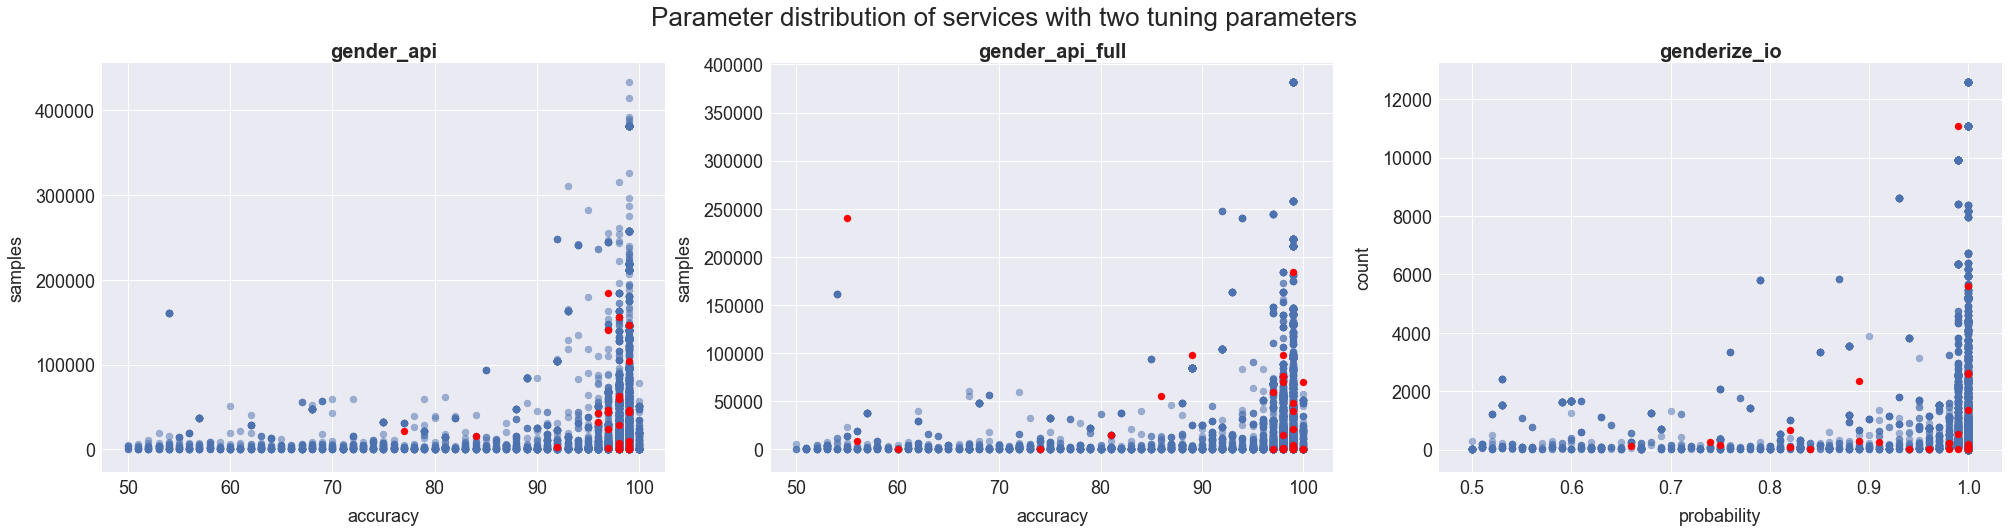

In [13]:
# plot for services with 2 parameters
rows = 1
cols = 3
fs=18
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(28, 7))
cmap = plt.get_cmap('PuRd')


evals = [GenderAPIEvaluator, GenderAPIFullEvaluator, GenderizeIoEvaluator]
for i, e in enumerate(evals):
    evaluator = e('all')
    evaluator.load_data(evaluated=True)
    evaluator.preprocess_tuning_params()
    evaluator._translate_api_response()
    evaluator.remove_rows_with_unknown_gender(gender=False, gender_infered=True)

    param_1, param_2 = evaluator.tuning_params[0], evaluator.tuning_params[1]
    evaluator.test_data.plot.scatter(ax=axes[i], x=param_1,  y=param_2, fontsize=fs, alpha=0.5, s=50)
    
    samples = pd.DataFrame.from_dict(grid_30_30[evaluator.gender_evaluator])
    samples = samples[samples.sum(axis=1)!=0] # remove default tuple (0,0)
    samples.head()
    samples.plot.scatter(ax=axes[i], x=param_1, y=param_2, fontsize=fs, c='red', alpha=1, s=50)
    
    axes[i].set_xlabel(param_1.replace("api_", ""), fontsize=fs, labelpad=10)
    axes[i].set_ylabel(param_2.replace("api_", ""), fontsize=fs, labelpad=10)
    axes[i].set_title(evaluator.gender_evaluator,fontweight="bold", size=20)

plt.suptitle('Parameter distribution of services with two tuning parameters', fontsize=fs+8, y=1.05)
fig.tight_layout()

## Benchmark by repeated cross validation

The larger the number of parameter values the smaller the error on the train set. however, choosing too many parameter values makes it harder to compare services with very few parameters and those with many, and it increases the probability of overfitting.

Hence we choose rather small parameter lists but repeat the 5-fold cross validation 10 times and count, who came first (second) how often. This ensures higher stability in the results.

In [14]:
# Wrapper around some methods to make code for tuning with different error functions shorter
def prepare_for_tuning(e):
    e.load_data(evaluated=True)
    e.preprocess_tuning_params()
    e._translate_api_response()
    e.remove_rows_with_unknown_gender(gender=True, gender_infered=False)
    e.shuffle_data()
    return e

def tune(error_func, param_ranges, constraint_func=None, constraint_val=None, verbose=True):
    service_to_test_error = {}
    for s in REGISTERED_EVALUATORS:  
        evaluator = s('all')
        evaluator_name = evaluator.gender_evaluator
        print(evaluator_name)

        evaluator = prepare_for_tuning(evaluator)
        
        param_range = param_ranges[evaluator_name]
        mean_test_error = evaluator.compute_k_fold_cv_score(n_splits=5, param_range=param_range, error_func=error_func, 
                                                    constraint_func=constraint_func, constraint_val=constraint_val, 
                                                    verbose=verbose)
        service_to_test_error[evaluator_name] = mean_test_error
    return service_to_test_error

def tune_repeat(error_func, n_params, n_repeat=10, constraint_func=None, constraint_val=None, verbose=False):
    service_to_test_error_repeat = []
    for i in range(n_repeat):
        param_ranges = sample_parameters_for_all_services(n_iter=n_params, method='constant', random_state=i)
        # print(param_ranges) # printed the params to check that these really differ in each repetition
        service_to_test_error = tune(error_func, param_ranges, constraint_func=constraint_func, 
                                                  constraint_val=constraint_val, verbose=verbose)
        service_to_test_error_repeat.append(list(sorted(service_to_test_error.items(), key=lambda t: t[1])))
    return service_to_test_error_repeat

def explore_benchmark(benchmark):
    """Determine services that made it to the first and second place, and create dataframe with their CV errors 
    in each of the repetitions."""
    first_service, second_service = [], []
    for i, item in enumerate(benchmark):
        # print("first place in iteration round ", i, " :", item[0])
        # print("second place in iteration round ", i, " :", item[1])
        first_service.append(item[0][0])
        second_service.append(item[1][0])

    errors_per_service_and_iteration = pd.DataFrame.from_dict([{i[0]:i[1] for i in item} for item in benchmark])
    errors_per_service_and_iteration.index = ['Iteration ' + str(i) for i in errors_per_service_and_iteration.index]
    errors_per_service_and_iteration.loc['average error'] = errors_per_service_and_iteration.mean()

    print("Services at place 1:", Counter(first_service))
    print("Services at place 2:", Counter(second_service))
    display(errors_per_service_and_iteration)
    return errors_per_service_and_iteration

def dump_benchmark_to_file(benchmark_table, file_name):
    writer = pd.ExcelWriter(file_name, engine='xlsxwriter')
    benchmark_table.to_excel(writer, sheet_name='Sheet1')
    workbook  = writer.book
    worksheet = writer.sheets['Sheet1']

    worksheet.conditional_format('B12:H12', {'type': '2_color_scale', 'min_color': light_green, 
                                             'max_color': dark_green})
    writer.save()

### Benchmark 1: minimize `error_with_unknown` with the constraint  `error_without_unknown < 0.05`
This benchmark means that the error of classifying women as men or 'unknown' and classifying men as women or 'unknown' is to be minimized, under the constraint that at most 5% of those classified as men or women have been missclassified.

In [15]:
benchmark_1 = tune_repeat(error_func=Evaluator.compute_error_with_unknown, n_params=40, n_repeat=10, 
                          constraint_func=Evaluator.compute_error_without_unknown, constraint_val=0.05, verbose=True)

gender_api
minimal train error: 0.0809173517958 corresponding test error: 0.0708729472774
params for lowest train error: {'api_accuracy': 0, 'api_samples': 0}
minimal train error: 0.0899848583171 corresponding test error: 0.110726643599
params for lowest train error: {'api_accuracy': 66, 'api_samples': 3438}
minimal train error: 0.0839281851612 corresponding test error: 0.0795847750865
params for lowest train error: {'api_accuracy': 98, 'api_samples': 8}
minimal train error: 0.0793685121107 corresponding test error: 0.0770562770563
params for lowest train error: {'api_accuracy': 0, 'api_samples': 0}
minimal train error: 0.0791522491349 corresponding test error: 0.0779220779221
params for lowest train error: {'api_accuracy': 0, 'api_samples': 0}
Average test error: 0.0832325441882
gender_api_full
minimal train error: 0.255084379057 corresponding test error: 0.249783923941
params for lowest train error: {'api_accuracy': 78, 'api_samples': 68146}
minimal train error: 0.253947653039 corres

minimal train error: 0.130030289918 corresponding test error: 0.121002592913
params for lowest train error: {'api_scale': 0.13}
minimal train error: 0.151416828899 corresponding test error: 0.170415224913
params for lowest train error: {'api_scale': 0.40999999999999998}
minimal train error: 0.130434782609 corresponding test error: 0.11937716263
params for lowest train error: {'api_scale': 0.13}
minimal train error: 0.130406574394 corresponding test error: 0.119480519481
params for lowest train error: {'api_scale': 0.13}
minimal train error: 0.152897923875 corresponding test error: 0.164502164502
params for lowest train error: {'api_scale': 0.40999999999999998}
Average test error: 0.138955532888
gender_guesser
minimal train error: 0.222414539161 corresponding test error: 0.222126188418
params for lowest train error: {'api_confidence': 0.75}
minimal train error: 0.215877136059 corresponding test error: 0.248269896194
params for lowest train error: {'api_confidence': 0.75}
minimal train e

minimal train error: 0.251839030723 corresponding test error: 0.23595505618
params for lowest train error: {'api_accuracy': 81, 'api_samples': 3947}
minimal train error: 0.259139087173 corresponding test error: 0.256055363322
params for lowest train error: {'api_accuracy': 81, 'api_samples': 11999}
minimal train error: 0.248972528661 corresponding test error: 0.247404844291
params for lowest train error: {'api_accuracy': 81, 'api_samples': 3947}
minimal train error: 0.245458477509 corresponding test error: 0.261471861472
params for lowest train error: {'api_accuracy': 81, 'api_samples': 3947}
minimal train error: 0.211937716263 corresponding test error: 0.2
params for lowest train error: {'api_accuracy': 60, 'api_samples': 14121}
Average test error: 0.240177425053
name_api
minimal train error: 0.233016010385 corresponding test error: 0.222126188418
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.245295262816 corresponding test error: 0.265570934256
params fo

minimal train error: 0.215877136059 corresponding test error: 0.248269896194
params for lowest train error: {'api_confidence': 0.75}
minimal train error: 0.226908933593 corresponding test error: 0.204152249135
params for lowest train error: {'api_confidence': 0.75}
minimal train error: 0.222750865052 corresponding test error: 0.220779220779
params for lowest train error: {'api_confidence': 0.75}
minimal train error: 0.223832179931 corresponding test error: 0.21645021645
params for lowest train error: {'api_confidence': 0.75}
Average test error: 0.222355554195
genderize_io
minimal train error: 0.146257031588 corresponding test error: 0.128781331029
params for lowest train error: {'api_probability': 0, 'api_count': 0}
minimal train error: 0.139087172831 corresponding test error: 0.157439446367
params for lowest train error: {'api_probability': 0, 'api_count': 0}
minimal train error: 0.147090633788 corresponding test error: 0.139273356401
params for lowest train error: {'api_probability':

minimal train error: 0.233016010385 corresponding test error: 0.222126188418
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.228855721393 corresponding test error: 0.254325259516
params for lowest train error: {'api_confidence': 0.72221900000000006}
minimal train error: 0.232965606749 corresponding test error: 0.2223183391
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.230752595156 corresponding test error: 0.231168831169
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.231617647059 corresponding test error: 0.227705627706
params for lowest train error: {'api_confidence': 0}
Average test error: 0.231528849182
name_api_full
minimal train error: 0.180657723929 corresponding test error: 0.174589455488
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.173696733723 corresponding test error: 0.202422145329
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.18

minimal train error: 0.139087172831 corresponding test error: 0.157439446367
params for lowest train error: {'api_probability': 0.90000000000000002, 'api_count': 1.0}
minimal train error: 0.153147306944 corresponding test error: 0.150519031142
params for lowest train error: {'api_probability': 0.56999999999999995, 'api_count': 9931.0}
minimal train error: 0.144896193772 corresponding test error: 0.153246753247
params for lowest train error: {'api_probability': 0.53000000000000003, 'api_count': 105.0}
minimal train error: 0.14446366782 corresponding test error: 0.135930735931
params for lowest train error: {'api_probability': 0.90000000000000002, 'api_count': 1.0}
Average test error: 0.145183459543
gender_api
minimal train error: 0.0809173517958 corresponding test error: 0.0708729472774
params for lowest train error: {'api_accuracy': 0, 'api_samples': 0}
minimal train error: 0.115509409474 corresponding test error: 0.135813148789
params for lowest train error: {'api_accuracy': 93, 'api_

minimal train error: 0.180657723929 corresponding test error: 0.174589455488
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.173696733723 corresponding test error: 0.202422145329
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.181700194679 corresponding test error: 0.170415224913
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.183607266436 corresponding test error: 0.162770562771
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.177551903114 corresponding test error: 0.187012987013
params for lowest train error: {'api_confidence': 0}
Average test error: 0.179442075103
namsor
minimal train error: 0.130030289918 corresponding test error: 0.121002592913
params for lowest train error: {'api_scale': 0.13}
minimal train error: 0.147523253299 corresponding test error: 0.167820069204
params for lowest train error: {'api_scale': 0.39000000000000001}
minimal train error: 0.130434782609 c

In [16]:
benchmark_1[0]

[('gender_api', 0.083232544188183558),
 ('namsor', 0.13532051738420076),
 ('genderize_io', 0.14397253667110982),
 ('name_api_full', 0.17944207510281923),
 ('gender_guesser', 0.22235555419529601),
 ('name_api', 0.23170185956236264),
 ('gender_api_full', 0.2427689898841876)]

In [17]:
errors_per_service_and_iteration_1 = explore_benchmark(benchmark_1)

Services at place 1: Counter({'gender_api': 10})
Services at place 2: Counter({'namsor': 9, 'genderize_io': 1})


,gender_api,gender_api_full,gender_guesser,genderize_io,name_api,name_api_full,namsor
Iteration 0,0.083233,0.242769,0.222356,0.143973,0.231702,0.179442,0.135321
Iteration 1,0.084098,0.240531,0.222356,0.143627,0.231875,0.179442,0.138956
Iteration 2,0.084271,0.228418,0.222356,0.146050,0.231529,0.179442,0.135494
Iteration 3,0.081848,0.240177,0.222356,0.143627,0.233778,0.179442,0.135321
Iteration 4,0.083060,0.233263,0.222356,0.143973,0.240871,0.179442,0.139302
Iteration 5,0.089807,0.251251,0.222356,0.143280,0.232048,0.179442,0.143283
Iteration 6,0.082540,0.230145,0.222356,0.144839,0.231529,0.179442,0.136878
Iteration 7,0.082021,0.238793,0.222356,0.145183,0.235162,0.179442,0.139302
Iteration 8,0.087904,0.231357,0.222356,0.143627,0.233259,0.179442,0.140686
Iteration 9,0.088077,0.233605,0.222356,0.143454,0.237065,0.179442,0.136878


In [18]:
df = errors_per_service_and_iteration_1
df = reduce_table(df, by_index=False)
df = df.round(3)

In [19]:
df

,Gender API,NamSor,NameAPI,gender-guesser,genderize.io
Iteration 0,0.083,0.135,0.179,0.222,0.144
Iteration 1,0.084,0.139,0.179,0.222,0.144
Iteration 2,0.084,0.135,0.179,0.222,0.146
Iteration 3,0.082,0.135,0.179,0.222,0.144
Iteration 4,0.083,0.139,0.179,0.222,0.144
Iteration 5,0.090,0.143,0.179,0.222,0.143
Iteration 6,0.083,0.137,0.179,0.222,0.145
Iteration 7,0.082,0.139,0.179,0.222,0.145
Iteration 8,0.088,0.141,0.179,0.222,0.144
Iteration 9,0.088,0.137,0.179,0.222,0.143


In [20]:
dump_benchmark_to_file(benchmark_table=df, file_name=DIR_PATH + '/paper/submission/Table3.xlsx')

### Benchmark 2: minimize `error_without_unknown` with the constraint  `error_unknown < 0.25`
This benchmark can be interpreted as follows: minimize the error of classifying women as men and vice versa, but under the constraint that at most 25% are left as 'unknown'. 

In [22]:
benchmark_2 = tune_repeat(error_func=Evaluator.compute_error_without_unknown, n_params=40, n_repeat=10, 
                     constraint_func=Evaluator.compute_error_unknown, constraint_val=0.25, verbose=True)

gender_api
minimal train error: 0.00720421169299 corresponding test error: 0.0122630992196
params for lowest train error: {'api_accuracy': 95, 'api_samples': 56140}
minimal train error: 0.00803992237316 corresponding test error: 0.00889877641824
params for lowest train error: {'api_accuracy': 95, 'api_samples': 56140}
minimal train error: 0.00862788755914 corresponding test error: 0.0065717415115
params for lowest train error: {'api_accuracy': 95, 'api_samples': 56140}
minimal train error: 0.00860632981677 corresponding test error: 0.00663716814159
params for lowest train error: {'api_accuracy': 95, 'api_samples': 56140}
minimal train error: 0.00858012731802 corresponding test error: 0.006718924972
params for lowest train error: {'api_accuracy': 95, 'api_samples': 56140}
Average test error: 0.00821794205259
gender_api_full
minimal train error: 0.0311428571429 corresponding test error: 0.0273348519362
params for lowest train error: {'api_accuracy': 81, 'api_samples': 84386}
minimal trai

minimal train error: 0.02949932341 corresponding test error: 0.0343680709534
params for lowest train error: {'api_confidence': 0.80918400000000001}
minimal train error: 0.0323369565217 corresponding test error: 0.0229007633588
params for lowest train error: {'api_confidence': 0.80918400000000001}
minimal train error: 0.0285631011367 corresponding test error: 0.026376146789
params for lowest train error: {'api_confidence': 0.86804899999999996}
minimal train error: 0.0270900087387 corresponding test error: 0.032183908046
params for lowest train error: {'api_confidence': 0.86804899999999996}
Average test error: 0.0302321589858
namsor
minimal train error: 0.0142387732749 corresponding test error: 0.0122086570477
params for lowest train error: {'api_scale': 0.70999999999999996}
minimal train error: 0.0139879319803 corresponding test error: 0.013230429989
params for lowest train error: {'api_scale': 0.70999999999999996}
minimal train error: 0.012987012987 corresponding test error: 0.01713062

minimal train error: 0.0122124396478 corresponding test error: 0.0157480314961
params for lowest train error: {'api_probability': 0.95999999999999996, 'api_count': 4381.0}
minimal train error: 0.0124681212808 corresponding test error: 0.0147559591373
params for lowest train error: {'api_probability': 0.95999999999999996, 'api_count': 4381.0}
Average test error: 0.0129180926008
gender_api
minimal train error: 0.00652667423383 corresponding test error: 0.0114285714286
params for lowest train error: {'api_accuracy': 96, 'api_samples': 63411}
minimal train error: 0.0076726342711 corresponding test error: 0.00681818181818
params for lowest train error: {'api_accuracy': 96, 'api_samples': 63411}
minimal train error: 0.00769011677585 corresponding test error: 0.00675675675676
params for lowest train error: {'api_accuracy': 96, 'api_samples': 63411}
minimal train error: 0.0076813655761 corresponding test error: 0.00678733031674
params for lowest train error: {'api_accuracy': 96, 'api_samples':

minimal train error: 0.0277777777778 corresponding test error: 0.0340285400659
params for lowest train error: {'api_confidence': 0.83142099999999997}
minimal train error: 0.0285949958757 corresponding test error: 0.0314253647587
params for lowest train error: {'api_confidence': 0.82553100000000001}
minimal train error: 0.0309843707157 corresponding test error: 0.0220264317181
params for lowest train error: {'api_confidence': 0.816299}
minimal train error: 0.0296892341842 corresponding test error: 0.0264608599779
params for lowest train error: {'api_confidence': 0.83142099999999997}
minimal train error: 0.0280244173141 corresponding test error: 0.0330760749724
params for lowest train error: {'api_confidence': 0.83142099999999997}
Average test error: 0.0294034542986
namsor
minimal train error: 0.0142387732749 corresponding test error: 0.0122086570477
params for lowest train error: {'api_scale': 0.70999999999999996}
minimal train error: 0.0139879319803 corresponding test error: 0.01323042

minimal train error: 0.0118409923879 corresponding test error: 0.0156950672646
params for lowest train error: {'api_probability': 0.94999999999999996, 'api_count': 9931.0}
minimal train error: 0.0118376550169 corresponding test error: 0.0157126823793
params for lowest train error: {'api_probability': 0.94999999999999996, 'api_count': 9931.0}
Average test error: 0.0126040107809
gender_api
minimal train error: 0.00917912404931 corresponding test error: 0.0126448893572
params for lowest train error: {'api_accuracy': 90, 'api_samples': 219085}
minimal train error: 0.00997113618473 corresponding test error: 0.00946372239748
params for lowest train error: {'api_accuracy': 90, 'api_samples': 219085}
minimal train error: 0.01 corresponding test error: 0.00935550935551
params for lowest train error: {'api_accuracy': 90, 'api_samples': 219085}
minimal train error: 0.00972404730618 corresponding test error: 0.0104493207941
params for lowest train error: {'api_accuracy': 90, 'api_samples': 219085}

minimal train error: 0.0365783410138 corresponding test error: 0.0426966292135
params for lowest train error: {'api_confidence': 0.81078700000000004}
Average test error: 0.0386789207164
name_api_full
minimal train error: 0.0279563880347 corresponding test error: 0.033185840708
params for lowest train error: {'api_confidence': 0.83951200000000004}
minimal train error: 0.0286031657873 corresponding test error: 0.0306818181818
params for lowest train error: {'api_confidence': 0.83951200000000004}
minimal train error: 0.0309192200557 corresponding test error: 0.0213243546577
params for lowest train error: {'api_confidence': 0.83951200000000004}
minimal train error: 0.0290982425814 corresponding test error: 0.027027027027
params for lowest train error: {'api_confidence': 0.85831400000000002}
minimal train error: 0.0275862068966 corresponding test error: 0.032992036405
params for lowest train error: {'api_confidence': 0.85831400000000002}
Average test error: 0.0290422153959
namsor
minimal tr

minimal train error: 0.0134265734266 corresponding test error: 0.0124293785311
params for lowest train error: {'api_probability': 0.94999999999999996, 'api_count': 5168.0}
minimal train error: 0.0124241548685 corresponding test error: 0.0103211009174
params for lowest train error: {'api_probability': 0.96999999999999997, 'api_count': 4373.0}
minimal train error: 0.0118565644881 corresponding test error: 0.0125714285714
params for lowest train error: {'api_probability': 0.96999999999999997, 'api_count': 4373.0}
minimal train error: 0.012629806343 corresponding test error: 0.015607580825
params for lowest train error: {'api_probability': 0.94999999999999996, 'api_count': 5168.0}
Average test error: 0.0122175004778
gender_api
minimal train error: 0.00764223039909 corresponding test error: 0.0114285714286
params for lowest train error: {'api_accuracy': 96, 'api_samples': 55041}
minimal train error: 0.00577367205543 corresponding test error: 0.00571428571429
params for lowest train error: {

In [23]:
errors_per_service_and_iteration_2 = explore_benchmark(benchmark_2)

Services at place 1: Counter({'gender_api': 10})
Services at place 2: Counter({'genderize_io': 5, 'namsor': 5})


,gender_api,gender_api_full,gender_guesser,genderize_io,name_api,name_api_full,namsor
Iteration 0,0.008218,0.030380,0.022892,0.014211,0.038663,0.029139,0.013815
Iteration 1,0.006527,0.030380,0.022892,0.012724,0.039050,0.030232,0.013815
Iteration 2,0.006135,0.033547,0.022892,0.012918,0.039109,0.029109,0.013815
Iteration 3,0.007505,0.030380,0.022892,0.014172,0.039688,0.029026,0.013815
Iteration 4,0.011417,0.035073,0.022892,0.020997,0.040752,0.029403,0.013815
Iteration 5,0.008132,0.039352,0.022892,0.012604,0.039635,0.028451,0.013815
Iteration 6,0.009867,0.034608,0.022892,0.027592,0.038935,0.028754,0.013815
Iteration 7,0.010432,0.039986,0.022892,0.013194,0.038679,0.029042,0.013815
Iteration 8,0.009380,0.035394,0.022892,0.012218,0.039517,0.033148,0.013815
Iteration 9,0.006406,0.033431,0.022892,0.020913,0.039276,0.029223,0.013815


In [24]:
df = errors_per_service_and_iteration_2
df = reduce_table(df, by_index=False)
df = df.round(3)
df

,Gender API,NamSor,NameAPI,gender-guesser,genderize.io
Iteration 0,0.008,0.014,0.029,0.023,0.014
Iteration 1,0.007,0.014,0.030,0.023,0.013
Iteration 2,0.006,0.014,0.029,0.023,0.013
Iteration 3,0.008,0.014,0.029,0.023,0.014
Iteration 4,0.011,0.014,0.029,0.023,0.021
Iteration 5,0.008,0.014,0.028,0.023,0.013
Iteration 6,0.010,0.014,0.029,0.023,0.028
Iteration 7,0.010,0.014,0.029,0.023,0.013
Iteration 8,0.009,0.014,0.033,0.023,0.012
Iteration 9,0.006,0.014,0.029,0.023,0.021


In [25]:
dump_benchmark_to_file(benchmark_table=df, file_name= DIR_PATH + '/paper/submission/Table4.xlsx')

### Benchmark 3: minimize `weighted_error` with weight w=0.2
The 'weighted error' with weight w=0.2 puts 5 times more weight on classifying women as men and vice versa than classifying both of them as 'unknown'

In [26]:
benchmark_3 = tune_repeat(error_func=Evaluator.compute_weighted_error, n_params=40, n_repeat=10, verbose=True)

gender_api
minimal train error: 0.0447655139744 corresponding test error: 0.0435193945128
params for lowest train error: {'api_accuracy': 76, 'api_samples': 139211}
minimal train error: 0.0435583691595 corresponding test error: 0.0483932670237
params for lowest train error: {'api_accuracy': 76, 'api_samples': 139211}
minimal train error: 0.0445603223513 corresponding test error: 0.0443396226415
params for lowest train error: {'api_accuracy': 76, 'api_samples': 139211}
minimal train error: 0.044885177453 corresponding test error: 0.0430532054898
params for lowest train error: {'api_accuracy': 76, 'api_samples': 139211}
minimal train error: 0.0448135529055 corresponding test error: 0.043321299639
params for lowest train error: {'api_accuracy': 76, 'api_samples': 139211}
Average test error: 0.0445253578613
gender_api_full
minimal train error: 0.0892498148344 corresponding test error: 0.0845813119595
params for lowest train error: {'api_accuracy': 78, 'api_samples': 68146}
minimal train er

minimal train error: 0.066794267766 corresponding test error: 0.069006543724
params for lowest train error: {'api_confidence': 0}
Average test error: 0.0672876376538
namsor
minimal train error: 0.0563352635195 corresponding test error: 0.0540273105086
params for lowest train error: {'api_scale': 0.5}
minimal train error: 0.0534671620904 corresponding test error: 0.0612764291308
params for lowest train error: {'api_scale': 0.40999999999999998}
minimal train error: 0.0558982079549 corresponding test error: 0.0515267175573
params for lowest train error: {'api_scale': 0.40999999999999998}
minimal train error: 0.0559694272446 corresponding test error: 0.0511727078891
params for lowest train error: {'api_scale': 0.40999999999999998}
minimal train error: 0.0533159319412 corresponding test error: 0.0618316157885
params for lowest train error: {'api_scale': 0.40999999999999998}
Average test error: 0.0559669561748
gender_guesser
minimal train error: 0.0726597172051 corresponding test error: 0.07

minimal train error: 0.0449973783307 corresponding test error: 0.0439497716895
params for lowest train error: {'api_accuracy': 78, 'api_samples': 78387}
minimal train error: 0.0450858778626 corresponding test error: 0.0436018957346
params for lowest train error: {'api_accuracy': 78, 'api_samples': 78387}
minimal train error: 0.0447057703295 corresponding test error: 0.0467522513892
params for lowest train error: {'api_accuracy': 79, 'api_samples': 46085}
Average test error: 0.0452649774882
gender_api_full
minimal train error: 0.0895177746751 corresponding test error: 0.0854572713643
params for lowest train error: {'api_accuracy': 81, 'api_samples': 101742}
minimal train error: 0.0881736607383 corresponding test error: 0.090811965812
params for lowest train error: {'api_accuracy': 81, 'api_samples': 101742}
minimal train error: 0.0889568905352 corresponding test error: 0.0876929674099
params for lowest train error: {'api_accuracy': 81, 'api_samples': 101742}
minimal train error: 0.08688

minimal train error: 0.0534531922092 corresponding test error: 0.0615203761755
params for lowest train error: {'api_scale': 0.42999999999999999}
minimal train error: 0.0558879322924 corresponding test error: 0.0517570664629
params for lowest train error: {'api_scale': 0.42999999999999999}
minimal train error: 0.0559643687064 corresponding test error: 0.05137186223
params for lowest train error: {'api_scale': 0.42999999999999999}
minimal train error: 0.0533017041053 corresponding test error: 0.0620743335279
params for lowest train error: {'api_scale': 0.42999999999999999}
Average test error: 0.056150189781
gender_guesser
minimal train error: 0.0726597172051 corresponding test error: 0.0750256937307
params for lowest train error: {'api_confidence': 0.75}
minimal train error: 0.0712272610812 corresponding test error: 0.0810067681895
params for lowest train error: {'api_confidence': 0.75}
minimal train error: 0.0753867646298 corresponding test error: 0.0642799023596
params for lowest train

minimal train error: 0.0896518060527 corresponding test error: 0.087069525666
params for lowest train error: {'api_accuracy': 83, 'api_samples': 97659}
minimal train error: 0.0871870243032 corresponding test error: 0.0967607973422
params for lowest train error: {'api_accuracy': 77, 'api_samples': 28436}
minimal train error: 0.0892679608602 corresponding test error: 0.088519764508
params for lowest train error: {'api_accuracy': 77, 'api_samples': 28436}
minimal train error: 0.0876110028157 corresponding test error: 0.0952692391541
params for lowest train error: {'api_accuracy': 83, 'api_samples': 97659}
minimal train error: 0.0898742411101 corresponding test error: 0.0861732146733
params for lowest train error: {'api_accuracy': 83, 'api_samples': 97659}
Average test error: 0.0907585082687
name_api
minimal train error: 0.0860575435702 corresponding test error: 0.0855517171307
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.0828250730357 corresponding test erro

minimal train error: 0.0533017041053 corresponding test error: 0.0620743335279
params for lowest train error: {'api_scale': 0.42999999999999999}
Average test error: 0.056150189781
gender_guesser
minimal train error: 0.0726597172051 corresponding test error: 0.0750256937307
params for lowest train error: {'api_confidence': 0.75}
minimal train error: 0.0712272610812 corresponding test error: 0.0810067681895
params for lowest train error: {'api_confidence': 0.75}
minimal train error: 0.0753867646298 corresponding test error: 0.0642799023596
params for lowest train error: {'api_confidence': 0.75}
minimal train error: 0.0723724963865 corresponding test error: 0.0761650585095
params for lowest train error: {'api_confidence': 0.75}
minimal train error: 0.0740454076367 corresponding test error: 0.0695044211392
params for lowest train error: {'api_confidence': 0.75}
Average test error: 0.0731963687857
genderize_io
minimal train error: 0.06575235872 corresponding test error: 0.0612401612594
para

minimal train error: 0.088056837629 corresponding test error: 0.0914735099338
params for lowest train error: {'api_accuracy': 73, 'api_samples': 72376}
minimal train error: 0.0866680489322 corresponding test error: 0.0970350404313
params for lowest train error: {'api_accuracy': 73, 'api_samples': 72376}
minimal train error: 0.0890710382514 corresponding test error: 0.0873103144931
params for lowest train error: {'api_accuracy': 85, 'api_samples': 219085}
Average test error: 0.0912470063995
name_api
minimal train error: 0.0860575435702 corresponding test error: 0.0855517171307
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.0828250730357 corresponding test error: 0.0986677768526
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.0881036877025 corresponding test error: 0.077380952381
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.0870123203285 corresponding test error: 0.081695966908
params for lowest train

In [27]:
errors_per_service_and_iteration_3 = explore_benchmark(benchmark_3)

Services at place 1: Counter({'gender_api': 10})
Services at place 2: Counter({'namsor': 10})


,gender_api,gender_api_full,gender_guesser,genderize_io,name_api,name_api_full,namsor
Iteration 0,0.044525,0.089017,0.073196,0.063204,0.085985,0.067288,0.056704
Iteration 1,0.044815,0.088707,0.073196,0.064662,0.085985,0.067288,0.055967
Iteration 2,0.044914,0.090620,0.073196,0.061195,0.085985,0.067288,0.057229
Iteration 3,0.045265,0.088707,0.073196,0.062675,0.085985,0.067288,0.057326
Iteration 4,0.046126,0.088270,0.073196,0.064157,0.085985,0.067288,0.056150
Iteration 5,0.045043,0.088382,0.073196,0.061743,0.086094,0.067288,0.055907
Iteration 6,0.045567,0.090759,0.073196,0.062774,0.085985,0.067288,0.056132
Iteration 7,0.045166,0.093437,0.073196,0.066102,0.085985,0.067288,0.056150
Iteration 8,0.049177,0.089108,0.073196,0.061697,0.085985,0.067288,0.057052
Iteration 9,0.047413,0.091247,0.073196,0.062140,0.085985,0.067288,0.056132


In [28]:
df = errors_per_service_and_iteration_3
df = reduce_table(df, by_index=False)
df = df.round(3)
df

,Gender API,NamSor,NameAPI,gender-guesser,genderize.io
Iteration 0,0.045,0.057,0.067,0.073,0.063
Iteration 1,0.045,0.056,0.067,0.073,0.065
Iteration 2,0.045,0.057,0.067,0.073,0.061
Iteration 3,0.045,0.057,0.067,0.073,0.063
Iteration 4,0.046,0.056,0.067,0.073,0.064
Iteration 5,0.045,0.056,0.067,0.073,0.062
Iteration 6,0.046,0.056,0.067,0.073,0.063
Iteration 7,0.045,0.056,0.067,0.073,0.066
Iteration 8,0.049,0.057,0.067,0.073,0.062
Iteration 9,0.047,0.056,0.067,0.073,0.062


In [29]:
dump_benchmark_to_file(benchmark_table=df, file_name=DIR_PATH + '/paper/submission/Table5.xlsx')

## Compute models for each benchmark

In [30]:
def compute_final_models(error_func, constraint_func, constraint_val, n_params=40):
    service_to_best_param = {}
    param_ranges = sample_parameters_for_all_services(n_iter=n_params, method='constant', random_state=1)
    
    for s in REGISTERED_EVALUATORS:  
        evaluator = s('all')
        evaluator_name = evaluator.gender_evaluator
        
        evaluator = prepare_for_tuning(evaluator)
        param_range = param_ranges[evaluator_name]
        train_index = evaluator.test_data.index
        test_index = evaluator.test_data.index # train and test index the same since we are only looking for best model
        test_error, train_error, best_param = evaluator.tune_params(param_range, error_func, train_index, test_index, 
                                                                constraint_func, constraint_val)
        print("Evaluator name: ", evaluator_name)
        print("Error: ", train_error)
        service_to_best_param[evaluator_name] = best_param
        
    return service_to_best_param

def explore_models(service, params):
    e = service('all')
    e.load_data(evaluated=True)
    e.preprocess_tuning_params()
    e._translate_api_response(**params)
    return e

In [31]:
print("Benchmark 1:")
# Optimal model parameters for Benchmark 1
service_to_best_param_1 = compute_final_models(error_func=Evaluator.compute_error_with_unknown,
                                               constraint_func=Evaluator.compute_error_without_unknown, 
                                               constraint_val=0.05)
print("Benchmark 2:")
# Optimal model parameters for Benchmark 2
service_to_best_param_2 = compute_final_models(error_func=Evaluator.compute_error_without_unknown, 
                                               constraint_func=Evaluator.compute_error_unknown, 
                                               constraint_val=0.25)
print("Benchmark 3:")
# Optimal model parameters for Benchmark 3
service_to_best_param_3 = compute_final_models(error_func=Evaluator.compute_weighted_error,
                                               constraint_func=None, 
                                               constraint_val=None)

Benchmark 1:
Evaluator name:  gender_api
Error:  0.0799446270981
Evaluator name:  gender_api_full
Error:  0.254715348676
Evaluator name:  name_api
Error:  0.230835784738
Evaluator name:  name_api_full
Error:  0.179442810175
Evaluator name:  namsor
Error:  0.12822287593
Evaluator name:  gender_guesser
Error:  0.222356809137
Evaluator name:  genderize_io
Error:  0.146392109361
Benchmark 2:
Evaluator name:  gender_api
Error:  0.0100650031453
Evaluator name:  gender_api_full
Error:  0.0303791685701
Evaluator name:  name_api
Error:  0.0390376758965
Evaluator name:  name_api_full
Error:  0.0304546443333
Evaluator name:  namsor
Error:  0.0138370305293
Evaluator name:  gender_guesser
Error:  0.0264298093588
Evaluator name:  genderize_io
Error:  0.0127272727273
Benchmark 3:
Evaluator name:  gender_api
Error:  0.0448126529844
Evaluator name:  gender_api_full
Error:  0.088703791164
Evaluator name:  name_api
Error:  0.0859551717047
Evaluator name:  name_api_full
Error:  0.0672331720367
Evaluator n

### Optimal values of the tuning parameter per service and benchmark metric

In [32]:
service_to_best_param_1

{'gender_api': {'api_accuracy': 57, 'api_samples': 62},
 'gender_api_full': {'api_accuracy': 89, 'api_samples': 1458},
 'gender_guesser': {'api_confidence': 0.75},
 'genderize_io': {'api_count': 4373.0, 'api_probability': 0.52000000000000002},
 'name_api': {'api_confidence': 0},
 'name_api_full': {'api_confidence': 0},
 'namsor': {'api_scale': 0.13}}

In [33]:
service_to_best_param_2

{'gender_api': {'api_accuracy': 90, 'api_samples': 137366},
 'gender_api_full': {'api_accuracy': 81, 'api_samples': 104026},
 'gender_guesser': {'api_confidence': 0.75},
 'genderize_io': {'api_count': 8180.0, 'api_probability': 0.95999999999999996},
 'name_api': {'api_confidence': 0.80226399999999998},
 'name_api_full': {'api_confidence': 0.80918400000000001},
 'namsor': {'api_scale': 0.70999999999999996}}

In [34]:
service_to_best_param_3

{'gender_api': {'api_accuracy': 75, 'api_samples': 72003},
 'gender_api_full': {'api_accuracy': 81, 'api_samples': 104026},
 'gender_guesser': {'api_confidence': 0.75},
 'genderize_io': {'api_count': 445.0, 'api_probability': 0.75},
 'name_api': {'api_confidence': 0},
 'name_api_full': {'api_confidence': 0},
 'namsor': {'api_scale': 0.40999999999999998}}

### Benchmark 1

In [35]:
# Gender API
gender_api = explore_models(GenderAPIEvaluator, service_to_best_param_1['gender_api'])
gender_api_errors_m_f = gender_api.compare_ground_truth_with_inference(gender='m', 
                                                                       gender_infered='f').sort_values('api_accuracy',
                                                                                                       ascending=False)
gender_api_errors_f_m = gender_api.compare_ground_truth_with_inference(gender='f', 
                                                                       gender_infered='m').sort_values('api_accuracy',
                                                                                                       ascending=False)
# NamSor
namsor = explore_models(NamSorEvaluator, service_to_best_param_1['namsor'])
namsor_errors_m_f = namsor.compare_ground_truth_with_inference(gender='m',
                                                               gender_infered='f').sort_values('api_scale',
                                                                                               ascending=False)
namsor_errors_f_m = namsor.compare_ground_truth_with_inference(gender='f',
                                                               gender_infered='m').sort_values('api_scale',
                                                                                               ascending=False)


In [36]:
print("Number of m-f errors by Gender API:", len(gender_api_errors_m_f))
print("Number of m-f errors by NamSor:", len(namsor_errors_m_f))

Number of m-f errors by Gender API: 104
Number of m-f errors by NamSor: 131


In [37]:
print("Number of f-m errors by Gender API:", len(gender_api_errors_f_m))
print("Number of f-m errors by NamSor:", len(namsor_errors_f_m))

Number of f-m errors by Gender API: 170
Number of f-m errors by NamSor: 93


For Benchmark 1, Gender API introduces a high Gender Bias:

In [38]:
# print ErrorGenderBias for Gender API
print(gender_api.compute_all_errors()[2])

-0.0118046861027


In [39]:
# print ErrorGenderBias for NamSor
print(namsor.compute_all_errors()[2])

0.00722158874952


In [40]:
namsor_errors_m_f

,first_name,middle_name,last_name,full_name,gender,origin,api_firstName,api_gender,api_lastName,api_scale,gender_infered
5108,aza,,mohammed,aza mohammed,m,nature,aza,female,mohammed,1.00,f
3808,natsuki,,matsumoto,natsuki matsumoto,m,nature,natsuki,female,matsumoto,1.00,f
5094,jani,,sainio,jani sainio,m,nature,jani,female,sainio,1.00,f
5067,tomomi,,matsui,tomomi matsui,m,nature,tomomi,female,matsui,1.00,f
5060,lakshmi,,narasimhan,lakshmi narasimhan,m,nature,lakshmi,female,narasimhan,1.00,f
5039,hiromi,,yamashita,hiromi yamashita,m,nature,hiromi,female,yamashita,1.00,f
2664,devi,,nampiaparampil,devi nampiaparampil,m,filardo,devi,female,nampiaparampil,1.00,f
3005,arathi,,setty,arathi setty,m,filardo,arathi,female,setty,1.00,f
1142,ashley,,morris,ashley morris,m,genderizeR_titles,ashley,female,morris,1.00,f
3651,didarul,,chowdhury,didarul chowdhury,m,nature,didarul,female,chowdhury,1.00,f


In [41]:
namsor_errors_f_m

,first_name,middle_name,last_name,full_name,gender,origin,api_firstName,api_gender,api_lastName,api_scale,gender_infered
3595,puay,hoon,tan,puay hoon tan,f,nature,puay hoon,male,tan,1.00,m
724,comrade,,parvati,comrade parvati,f,genderizeR,comrade,male,parvati,1.00,m
3624,saim,,norashikin,saim norashikin,f,nature,saim,male,norashikin,1.00,m
3474,subramaniam,,mythily,subramaniam mythily,f,nature,subramaniam,male,mythily,1.00,m
2124,rory,,collins,rory collins,f,filardo,rory,male,collins,1.00,m
6153,minh,,huynh,minh huynh,f,nature,minh,male,huynh,1.00,m
3548,keo,,tabane,keo tabane,f,nature,keo,male,tabane,1.00,m
2317,mishal,sameer,khan,mishal sameer khan,f,filardo,mishal sameer,male,khan,1.00,m
4601,fernanda,rodrigues,fernandes,fernanda rodrigues fernandes,f,nature,fernanda-rodrigues,male,fernandes,1.00,m
1813,terry,,davis,terry davis,f,filardo,terry,male,davis,0.99,m


### Benchmark 2

As seen above, the services `Gender API`, `genderize.io` and `NamSor` have very similar error values.

In [42]:
# Gender API
gender_api = explore_models(GenderAPIEvaluator, service_to_best_param_2['gender_api'])
gender_api_errors_m_f = gender_api.compare_ground_truth_with_inference(gender='m', 
                                                                       gender_infered='f').sort_values('api_accuracy',
                                                                                                       ascending=False)
gender_api_errors_f_m = gender_api.compare_ground_truth_with_inference(gender='f', 
                                                                       gender_infered='m').sort_values('api_accuracy',
                                                                                                       ascending=False)
# NamSor
namsor = explore_models(NamSorEvaluator, service_to_best_param_2['namsor'])
namsor_errors_m_f = namsor.compare_ground_truth_with_inference(gender='m',
                                                               gender_infered='f').sort_values('api_scale',
                                                                                               ascending=False)
namsor_errors_f_m = namsor.compare_ground_truth_with_inference(gender='f',
                                                               gender_infered='m').sort_values('api_scale',
                                                                                               ascending=False)

# NameAPI
name_api = explore_models(NameAPIFullEvaluator, service_to_best_param_2['name_api_full'])
name_api_errors_m_f = name_api.compare_ground_truth_with_inference(gender='m',
                                                                   gender_infered='f').sort_values('api_confidence',
                                                                                                   ascending=False)
name_api_errors_f_m = name_api.compare_ground_truth_with_inference(gender='f',
                                                                   gender_infered='m').sort_values('api_confidence',
                                                                                                   ascending=False)

# genderize.io
genderize_io = explore_models(GenderizeIoEvaluator, service_to_best_param_2['genderize_io'])
genderize_io_errors_m_f = genderize_io.compare_ground_truth_with_inference(gender='m',
                                                                           gender_infered='f').sort_values('api_probability',
                                                                                                           ascending=False)
genderize_io_errors_f_m = genderize_io.compare_ground_truth_with_inference(gender='f',
                                                                           gender_infered='m').sort_values('api_probability',
                                                                                                           ascending=False)

# gender-guesser
gender_guesser = explore_models(GenderGuesserEvaluator, service_to_best_param_2['gender_guesser'])
gender_guesser_errors_m_f = gender_guesser.compare_ground_truth_with_inference(gender='m',
                                                                               gender_infered='f').sort_values('api_confidence',
                                                                                                               ascending=False)
gender_guesser_errors_f_m = gender_guesser.compare_ground_truth_with_inference(gender='f',
                                                                               gender_infered='m').sort_values('api_confidence',
                                                                                                               ascending=False)

In [43]:
print("Number of m-f errors by Gender API:", len(gender_api_errors_m_f))
print("Number of m-f errors by NamSor:", len(namsor_errors_m_f))
print("Number of m-f errors by NameAPI:", len(name_api_errors_m_f))
print("Number of m-f errors by genderize_io:", len(genderize_io_errors_m_f))
print("Number of m-f errors by gender-guesser:", len(gender_guesser_errors_m_f))

Number of m-f errors by Gender API: 15
Number of m-f errors by NamSor: 40
Number of m-f errors by NameAPI: 77
Number of m-f errors by genderize_io: 40
Number of m-f errors by gender-guesser: 66


In [44]:
print("Number of f-m errors by Gender API:", len(gender_api_errors_f_m))
print("Number of f-m errors by NamSor:", len(namsor_errors_f_m))
print("Number of f-m errors by NameAPI:", len(name_api_errors_f_m))
print("Number of f-m errors by genderize_io:", len(genderize_io_errors_f_m))
print("Number of f-m errors by gender-guesser:", len(gender_guesser_errors_f_m))

Number of f-m errors by Gender API: 33
Number of f-m errors by NamSor: 23
Number of f-m errors by NameAPI: 63
Number of f-m errors by genderize_io: 16
Number of f-m errors by gender-guesser: 56


In [45]:
# print ErrorGenderBias for Gender API
print(gender_api.compute_all_errors()[2])

-0.00377437617949


In [46]:
# print ErrorGenderBias for NamSor
print(namsor.compute_all_errors()[2])

0.00373380188886


In [47]:
gender_api_errors_f_m

,first_name,middle_name,last_name,full_name,gender,origin,api_accuracy,api_duration,gender_infered,api_name,api_samples,api_gender
6204,chang,hyun,kim,chang hyun kim,f,nature,100,32ms,m,chang hyun,39,male
5210,yongfu,,he,yongfu he,f,nature,100,23ms,m,yongfu,12,male
3391,yongsoon,,park,yongsoon park,f,nature,100,43ms,m,yongsoon,6,male
3474,subramaniam,,mythily,subramaniam mythily,f,nature,100,17ms,m,subramaniam,205,male
3476,soshan,,cheong,soshan cheong,f,nature,100,18ms,m,soshan,5,male
5204,zhongqiang,,yang,zhongqiang yang,f,nature,100,82ms,m,zhongqiang,4,male
3495,suryun,,ham,suryun ham,f,nature,100,29ms,m,suryun,3,male
3563,titipun,,thongtem,titipun thongtem,f,nature,100,18ms,m,titipun,3,male
3589,sangwoon,,yoon,sangwoon yoon,f,nature,100,28ms,m,sangwoon,11,male
6220,taciana,marco,ferraz caneppele,taciana marco ferraz caneppele,f,nature,99,96ms,m,taciana-marco,132431,male


In [48]:
namsor_errors_f_m

,first_name,middle_name,last_name,full_name,gender,origin,api_firstName,api_gender,api_lastName,api_scale,gender_infered
724,comrade,,parvati,comrade parvati,f,genderizeR,comrade,male,parvati,1.00,m
3474,subramaniam,,mythily,subramaniam mythily,f,nature,subramaniam,male,mythily,1.00,m
6153,minh,,huynh,minh huynh,f,nature,minh,male,huynh,1.00,m
4601,fernanda,rodrigues,fernandes,fernanda rodrigues fernandes,f,nature,fernanda-rodrigues,male,fernandes,1.00,m
3595,puay,hoon,tan,puay hoon tan,f,nature,puay hoon,male,tan,1.00,m
3548,keo,,tabane,keo tabane,f,nature,keo,male,tabane,1.00,m
3624,saim,,norashikin,saim norashikin,f,nature,saim,male,norashikin,1.00,m
2317,mishal,sameer,khan,mishal sameer khan,f,filardo,mishal sameer,male,khan,1.00,m
2124,rory,,collins,rory collins,f,filardo,rory,male,collins,1.00,m
1813,terry,,davis,terry davis,f,filardo,terry,male,davis,0.99,m


### Benchmark 3:

In [49]:
# Gender API
gender_api = explore_models(GenderAPIEvaluator, service_to_best_param_3['gender_api'])
gender_api_errors_m_f = gender_api.compare_ground_truth_with_inference(gender='m', 
                                                                       gender_infered='f').sort_values('api_accuracy',
                                                                                                       ascending=False)
gender_api_errors_f_m = gender_api.compare_ground_truth_with_inference(gender='f', 
                                                                       gender_infered='m').sort_values('api_accuracy',
                                                                                                       ascending=False)
# NamSor
namsor = explore_models(NamSorEvaluator, service_to_best_param_3['namsor'])
namsor_errors_m_f = namsor.compare_ground_truth_with_inference(gender='m',
                                                               gender_infered='f').sort_values('api_scale',
                                                                                               ascending=False)
namsor_errors_f_m = namsor.compare_ground_truth_with_inference(gender='f',
                                                               gender_infered='m').sort_values('api_scale',
                                                                                               ascending=False)

# NameAPI
name_api = explore_models(NameAPIFullEvaluator, service_to_best_param_3['name_api_full'])
name_api_errors_m_f = name_api.compare_ground_truth_with_inference(gender='m',
                                                                   gender_infered='f').sort_values('api_confidence',
                                                                                                   ascending=False)
name_api_errors_f_m = name_api.compare_ground_truth_with_inference(gender='f',
                                                                   gender_infered='m').sort_values('api_confidence',
                                                                                                   ascending=False)

# genderize.io
genderize_io = explore_models(GenderizeIoEvaluator, service_to_best_param_3['genderize_io'])
genderize_io_errors_m_f = genderize_io.compare_ground_truth_with_inference(gender='m',
                                                                           gender_infered='f').sort_values('api_probability',
                                                                                                           ascending=False)
genderize_io_errors_f_m = genderize_io.compare_ground_truth_with_inference(gender='f',
                                                                           gender_infered='m').sort_values('api_probability',
                                                                                                           ascending=False)

# gender-guesser
gender_guesser = explore_models(GenderGuesserEvaluator, service_to_best_param_3['gender_guesser'])
gender_guesser_errors_m_f = gender_guesser.compare_ground_truth_with_inference(gender='m',
                                                                               gender_infered='f').sort_values('api_confidence',
                                                                                                               ascending=False)
gender_guesser_errors_f_m = gender_guesser.compare_ground_truth_with_inference(gender='f',
                                                                               gender_infered='m').sort_values('api_confidence',
                                                                                                               ascending=False)

In [50]:
print("Number of m-f errors by Gender API:", len(gender_api_errors_m_f))
print("Number of m-f errors by NamSor:", len(namsor_errors_m_f))
print("Number of m-f errors by NameAPI:", len(name_api_errors_m_f))
print("Number of m-f errors by genderize_io:", len(genderize_io_errors_m_f))
print("Number of m-f errors by gender-guesser:", len(gender_guesser_errors_m_f))

Number of m-f errors by Gender API: 45
Number of m-f errors by NamSor: 69
Number of m-f errors by NameAPI: 93
Number of m-f errors by genderize_io: 121
Number of m-f errors by gender-guesser: 66


In [51]:
print("Number of f-m errors by Gender API:", len(gender_api_errors_f_m))
print("Number of f-m errors by NamSor:", len(namsor_errors_f_m))
print("Number of f-m errors by NameAPI:", len(name_api_errors_f_m))
print("Number of f-m errors by genderize_io:", len(genderize_io_errors_f_m))
print("Number of f-m errors by gender-guesser:", len(gender_guesser_errors_f_m))

Number of f-m errors by Gender API: 76
Number of f-m errors by NamSor: 62
Number of f-m errors by NameAPI: 75
Number of f-m errors by genderize_io: 45
Number of f-m errors by gender-guesser: 56


## Exploration of the parameter space for the benchmark winner  `genderAPI`

In [55]:
gender_api = GenderAPIEvaluator('all')
gender_api.load_data(evaluated=True)
gender_api.preprocess_tuning_params()
gender_api._translate_api_response()
gender_api.remove_rows_with_unknown_gender(gender=False, gender_infered=True)

gender_api_range = gender_api.sample_parameters(n_iter=40, method='square', random_state=0)

In [56]:
len(gender_api_range)

1393

In [57]:
error_with_unknown = gender_api.compute_error_for_param_range(param_range=gender_api_range, 
                                                              error_func=Evaluator.compute_error_with_unknown, 
                                                              index=evaluator.test_data.index)

error_without_unknown = gender_api.compute_error_for_param_range(param_range=gender_api_range, 
                                                                 error_func=Evaluator.compute_error_without_unknown, 
                                                                 index=evaluator.test_data.index)

In [58]:
df_error_with_unknown = pd.Series(error_with_unknown).reset_index()
df_error_without_unknown = pd.Series(error_without_unknown).reset_index()

df_error_with_unknown.columns=['samples', 'accuracy', 'error_with_unknown']
df_error_without_unknown.columns=['samples', 'accuracy', 'error_without_unknown']

In [59]:
df_error_with_unknown.head()

,samples,accuracy,error_with_unknown
0,0,0,0.050412
1,50,22561,0.050412
2,50,34211,0.050412
3,51,1741,0.050779
4,51,3076,0.050779


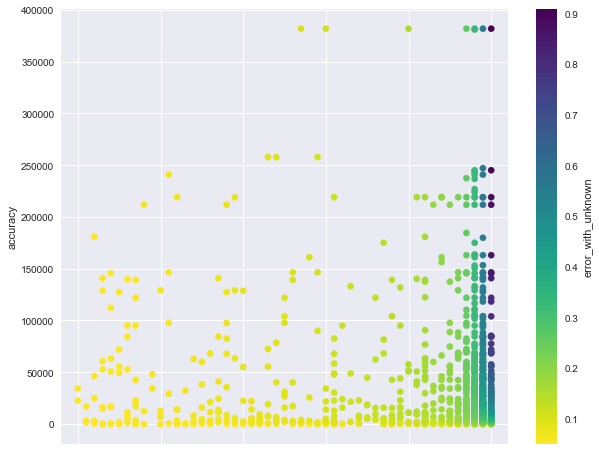

In [60]:
df_error_with_unknown.plot.scatter(x='samples', y='accuracy', c='error_with_unknown', xlim=(48,102), 
                                   cmap=plt.cm.get_cmap('viridis_r'), s=40, figsize=(10,8))

Here, we see the expected trend: the higher either of the parameter values, the higher the `error_with_unknown`.

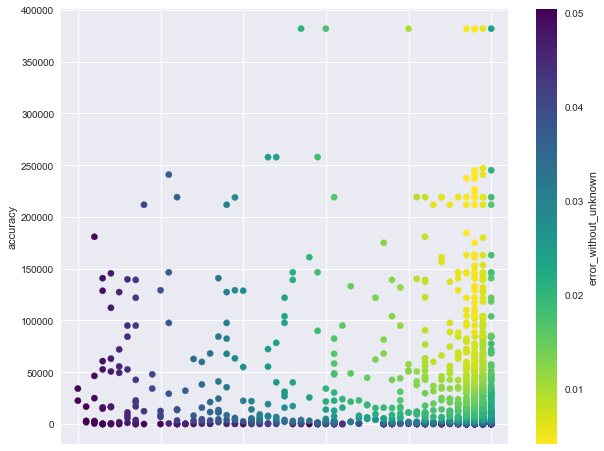

In [61]:
df_error_without_unknown.plot.scatter(x='samples', y='accuracy', c='error_without_unknown', xlim=(48,102), 
                                      cmap=plt.cm.get_cmap('viridis_r'), s=40, figsize=(10,8))

The tendency with the `error_without_unknown` is that the higher both parameter values the lower the error. 
**However, the far right column is not intuitive and needs further exploration.**

## TODO: have a closer look into the wrong classifications